In [1]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)
assert "2." in tf.__version__, "This notebook is designed to run on TensorFlow 2.x"


TensorFlow version: 2.14.0


In [2]:
# Additional imports here
import os
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
from tqdm import tqdm   # For progress bar
import time

In [3]:
# Mount drive for data access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Initialize directories
gan_data_dir = '/content/drive/My Drive/ML-GroupProject/Processed_Data/GAN_Training'

classifier_train_dir = '/content/drive/My Drive/ML-GroupProject/Processed_Data/Classifier_Training'

classifier_test_dir = '/content/drive/My Drive/ML-GroupProject/Processed_Data/Classifier_Testing'

# Directory for saving generated images
fake_dir = '/content/drive/My Drive/ML-GroupProject/Generated_Images'
os.makedirs(fake_dir, exist_ok=True)

# Directory for saving plots
plot_dir = '/content/drive/My Drive/ML-GroupProject/Plots'
os.makedirs(plot_dir, exist_ok=True)

In [5]:
# Load dataset for GAN Training

batch_size = 32  # Adjust as needed

# Function to normalize images
def normalize_image(image):
    # Convert to greyscale
    image = tf.image.rgb_to_grayscale(image)      # Thought dataset was already grayscale...
    # Normalize the images to [-1, 1]
    image = (image - 127.5) / 127.5
    return image

# Load the dataset
gan_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    gan_data_dir,
    label_mode=None,        # No labels needed as this is unsupervised learning
    image_size=(256, 256),  # Images are already of this size
    batch_size=batch_size,
    shuffle=True
).map(normalize_image).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 3464 files belonging to 1 classes.


In [6]:
# Define the Generator architecture

def make_generator_model(noise_dim):
    model = tf.keras.Sequential()

    # Start with a dense layer that reshapes into 8x8x1024 tensor
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 1024)))  # Reshaping into a 3D tensor

    # Deconvolutional layers
    # Upscale to 16x16
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upscale to 32x32
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upscale to 64x64
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upscale to 128x128
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final layer: Upscale to 256x256
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))  # 1 filter for grayscale, 3 for RGB

    return model

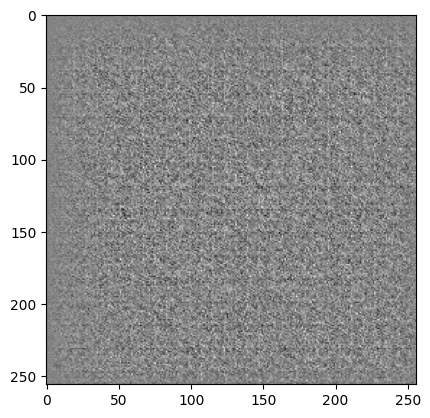

In [7]:
# Use the (as of yet untrained) generator to create an image

generator = make_generator_model(100)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [8]:
# Define Discriminator architecture

def make_discriminator_model():
    model = tf.keras.Sequential()

    # Input layer: 256x256x1
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(256, 256, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  # Used to prevent overfitting. Random set of neurons on each pass wont be used

    # Downsampling to 128x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsampling to 64x64
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())  # Provides more stable outputs, perfect for feature extracting!!!
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    # Downsampling to 32x32
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and final dense layer for classification
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
# Use the (as yet untrained) discriminator to classify the generated image as real or fake.

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-3.307398e-05]], shape=(1, 1), dtype=float32)


In [10]:
# Define loss functions

# Loss function for evaluating adversarial performance
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [11]:
# Initialize empty lists to store histories
discriminator_losses = []
discriminator_accuracies = []

In [12]:
# Setup save checkpoints

# Initialize a Tensorflow Variable to save epochs for intermittent training of model
start_epoch = tf.Variable(0, dtype=tf.int64)

checkpoint_dir = '/content/drive/My Drive/ML-GroupProject/Training_Checkpoints'
os.makedirs(plot_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 discriminator_losses=tf.Variable(discriminator_losses),
                                 discriminator_accuracies=tf.Variable(discriminator_accuracies),
                                 start_epoch=tf.Variable(0))  # Initialize start_epoch if not loading checkpoint

In [13]:
# Attempt to restore from checkpoint if one exists
latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint_path:
    checkpoint.restore(latest_checkpoint_path)
    discriminator_losses = checkpoint.discriminator_losses.numpy().tolist()
    discriminator_accuracies = checkpoint.discriminator_accuracies.numpy().tolist()
    start_epoch = checkpoint.start_epoch.numpy()  # Restore start_epoch
    print(f"Restored from checkpoint: {latest_checkpoint_path}")
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [14]:
# Function for saving generated images

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(os.path.join(fake_dir, f'image_at_epoch_{epoch:04d}.png'))
    plt.show()

In [15]:
# Create function for plotting and saving discriminator loss and accuracy

def plot_discriminator_metrics(total_epochs, losses, accuracies, plot_dir):

  plt.figure(figsize=(12,6))

  # Plot Discriminator loss
  plt.subplot(1,2,1)
  plt.plot(range(1, total_epochs + 1), losses, label='Discriminator Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Discriminator Loss Over Time')
  plt.legend()

  # Plot Discriminator accuracy
  plt.subplot(1,2,2)
  plt.plot(range(1, total_epochs + 1), accuracies, label='Discriminator Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Discriminator Accuracy Over Time')
  plt.legend()

  # Save the plot
  plt.tight_layout()
  plot_filename = os.path.joic(plot_dir, f'discriminator_metrics_epoch_{total_epochs}.png')
  plt.savefig(plot_filename)
  plt.close()

  print(f"Saved metrics plot to {plot_filename}")  # May not need this line of code

In [16]:
# Setup training loop

@tf.function      # TensorFlow decorator for efficiency. Converts function into TensorFlow graph
def train_step(images):
    # Generate random noise for the generator
    noise = tf.random.normal([batch_size, noise_dim])

    # Record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Discriminator outputs for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Compute generator and discriminator losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply graidents
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Calculate discriminator accuracy
    real_accuracy = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    d_accuracy = 0.5 * (real_accuracy + fake_accuracy)

    return gen_loss, disc_loss, d_accuracy

# Train function
def train(dataset, epochs, save_interval, plot_dir):

    # Extract the starting epoch from the checkpoint. convert from tensorflow obeject to numpy int
    start_epoch = checkpoint.start_epoch.numpy()

    # Calculate total number of epochs trained, including any from previous checkpoint(s)
    total_epochs_trained = start_epoch + epochs

    for epoch in range(start_epoch, total_epochs_trained):
        start = time.time()

        for image_batch in tqdm(dataset):
            # Training step
            gen_loss, disc_loss, d_accuracy = train_step(image_batch)

            # Append the loss and accuracy to the progress lists
            discriminator_losses.append(disc_loss.numpy())        # Must convert tensors to numpy scalars to plot
            discriminator_accuracies.append(d_accuracy.numpy())   # Must convert tensors to numpy scalars to plot

        # At the end of each save_interval, generate, display, and save images, then save the model
        if (epoch + 1) % save_interval == 0:
            # Produce images for monitoring progress
            generate_and_save_images(generator, epoch + 1, seed)

            # Plot and save metrics
            plot_discriminator_metrics(total_epochs_trained, discriminator_losses, discriminator_accuracies, plot_dir)

            # Save the model
            checkpoint.save(file_prefix=checkpoint_prefix)

            # Update the checkpoint lists
            checkpoint.discriminator_losses.assign(discriminator_losses)
            checkpoint.discriminator_accuracies.assign(discriminator_accuracies)

        # Save epoch
        checkpoint.start_epoch.assign(epoch + 1)
        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')


    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [17]:
# Final setup variables

EPOCHS = 100                    # Total number of epochs to run. Includes previous epochs if starting from a checkpoint.
noise_dim = 100                 # Adjust as needed
num_examples_to_generate = 16   # Adjust as needed
save_interval = 10              # Saves images and model, adjust as needed

# Seed for monitoring progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
# Start the training
train(gan_dataset, EPOCHS, save_interval, plot_dir)

TypeError: ignored